# Setup

In [120]:
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.current_device()
print(torch.cuda.get_device_name(n))

Tesla T4


# Preprocessing

## Reading from CSV

In [130]:
class LidarDataset(Dataset):
  def __init__(self, filename, transform=None):
    self.data = pd.read_csv(filename)
    self.data.drop(columns=self.data.columns[0], axis=1, inplace=True)
    print(self.data.head())
    print(f'NaN values: {self.data.isna().sum().sum()}')
    self.X = self.data.iloc[1:, 3:].values
    self.y = self.data.iloc[1:, :3].values
    self.X = torch.tensor(self.X, dtype=torch.float32)
    self.y = torch.tensor(self.y, dtype=torch.float32)
    self.transform = transform

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.y)

## Normalization

In [129]:
transform = transforms.Compose([transforms.ToTensor, transforms.Normalize([0.5], [0.5])])

In [137]:
lidar_dataset = LidarDataset('lidar_data_new.csv', transform=transform)

       x      y  player_angle  distance_0  distance_1  distance_2  distance_3  \
0  640.0  360.0          -0.1    0.442652    0.440641    0.440786    0.443091   
1  640.0  360.0          -0.2    0.643457    0.444199    0.441244    0.440460   
2  640.0  360.0          -0.3    0.660114    0.647715    0.638828    0.442253   
3  640.0  360.0          -0.4    0.684678    0.666641    0.652628    0.642257   
4  640.0  360.0          -0.5    0.501879    0.693849    0.673920    0.658221   

   distance_4  distance_5  distance_6  ...  distance_80  distance_81  \
0    0.336859    0.243653    0.202081  ...     0.195712     0.526355   
1    0.441827    0.404406    0.276602  ...     0.179170     0.190202   
2    0.440535    0.440971    0.443571  ...     0.166742     0.175041   
3    0.443671    0.441012    0.440519  ...     0.157397     0.163633   
4    0.646314    0.637883    0.441894  ...     0.150468     0.155075   

   distance_82  distance_83  distance_84  distance_85  distance_86  \
0     0.55

## Train-Test Split

In [138]:
lidar_train, lidar_test = random_split(lidar_dataset, [0.8, 0.2])
train_loader = DataLoader(dataset=lidar_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=lidar_test, batch_size=100, shuffle=True)
print(f'Training records: {len(train_loader.dataset)} Testing records: {len(test_loader.dataset)}')

Training records: 2256 Testing records: 563


# Model

In [41]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, output_size, *layer_size):
    super(SimpleNN, self).__init__()
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(input_size, layer_size[0]))
    for i in range(1, len(layer_size)):
      self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))
    self.layers.append(nn.Linear(layer_size[-1], output_size))

  def forward(self, x):
    for i in range(len(self.layers)):
      x = self.layers[i](x)
      if i < len(self.layers) - 1:
        x = self.relu(x)
    return x

# Training and Testing Methods

In [127]:
def test_model(model, criterion, dataloader, gpu=None):
  with torch.no_grad():
    avg_test_loss = 0
    for (x, y) in dataloader:
      if (gpu is not None):
        x, y = x.to(gpu), y.to(gpu)
      preds = model(x)
      avg_test_loss += criterion(preds, y)
    avg_test_loss /= len(dataloader.dataset)
    return avg_test_loss

In [128]:
def train_model(model, optimizer, criterion, epochs, train_loader, test_loader, gpu=None):
  time1 = time.time()
  train_loss_history, val_loss_history = [], []
  for epoch in range(epochs):
    epoch_loss = None
    for i, (x, y) in enumerate(train_loader):
      if (gpu is not None):
        x, y = x.to(gpu), y.to(gpu)
      preds = model(x)
      loss = criterion(preds, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss = loss.item()
    if (epoch + 1) % 100 == 0:
      train_loss_history.append(epoch_loss)
      val_loss_history.append(test_model(model, criterion, test_loader, gpu))
      if (epoch + 1) % 500 == 0:
        print(f'Epoch {epoch + 1} of {epochs}: Train Loss = {epoch_loss:.4f} Val Loss = {val_loss_history[-1].cpu()}')
  time2 = time.time()
  print(f'Training Time: {time2 - time1} seconds')
  return train_loss_history, val_loss_history

In [125]:
def plot_loss(train_loss_history, val_loss_history):
  x = [i * 100 for i in range(len(train_loss_history))]
  if val_loss_history[0].device.type != 'cpu':
    val_loss_history = [i.cpu() for i in val_loss_history]
  plt.plot(x, train_loss_history, label='Train Loss')
  plt.legend()
  plt.show()
  plt.plot(x, val_loss_history, label='Val Loss')
  plt.legend()
  plt.show()

# CPU Training

In [80]:
criterion = nn.MSELoss()

In [142]:
model_1 = SimpleNN(90, 3, 360, 180, 45)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [143]:
history_train, history_val = train_model(model_1, optimizer_1, criterion, 4000, train_loader, test_loader)

Epoch 500 of 4000: Train Loss = 1211.6447 Val Loss = 173.89720153808594
Epoch 1000 of 4000: Train Loss = 388.9481 Val Loss = 1083433.75
Epoch 1500 of 4000: Train Loss = 333.6525 Val Loss = 5698186.0
Epoch 2000 of 4000: Train Loss = 237.6855 Val Loss = 36681380.0
Epoch 2500 of 4000: Train Loss = 212.3737 Val Loss = 50587596.0
Epoch 3000 of 4000: Train Loss = 84.9097 Val Loss = 95401824.0
Epoch 3500 of 4000: Train Loss = 113.1331 Val Loss = 94077840.0
Epoch 4000 of 4000: Train Loss = 90.2641 Val Loss = 102883664.0
Training Time: 417.52784061431885 seconds


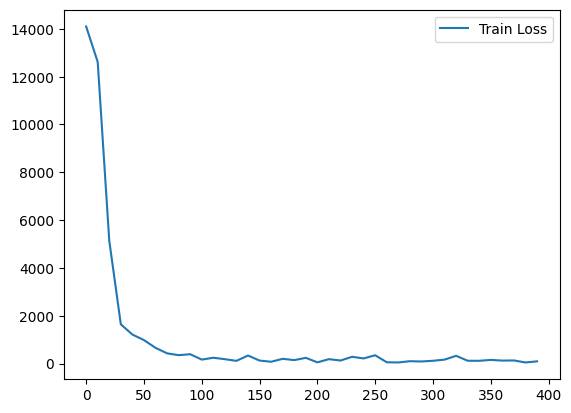

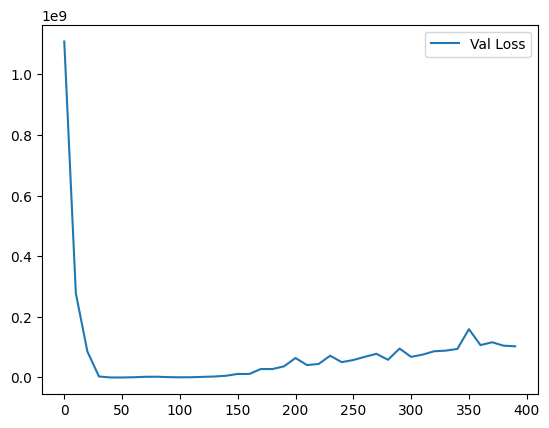

In [145]:
plot_loss(history_train, history_val)

# GPU Training

In [87]:
device

device(type='cuda')

In [146]:
model_2 = SimpleNN(90, 3, 360, 180, 45)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)
model_2.to(device)

SimpleNN(
  (relu): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=90, out_features=360, bias=True)
    (1): Linear(in_features=360, out_features=180, bias=True)
    (2): Linear(in_features=180, out_features=45, bias=True)
    (3): Linear(in_features=45, out_features=3, bias=True)
  )
)

In [147]:
history_train, history_val = train_model(model_2, optimizer_2, criterion, 4000, train_loader, test_loader, device)

Epoch 500 of 4000: Train Loss = 1841.5586 Val Loss = 5896.9892578125
Epoch 1000 of 4000: Train Loss = 395.9438 Val Loss = 3969.282470703125
Epoch 1500 of 4000: Train Loss = 153.0907 Val Loss = 21029.287109375
Epoch 2000 of 4000: Train Loss = 92.3341 Val Loss = 1520521.75
Epoch 2500 of 4000: Train Loss = 92.8736 Val Loss = 5257683.5
Epoch 3000 of 4000: Train Loss = 98.3946 Val Loss = 17927448.0
Epoch 3500 of 4000: Train Loss = 93.9060 Val Loss = 56663936.0
Epoch 4000 of 4000: Train Loss = 52.8637 Val Loss = 83212944.0
Training Time: 251.1725754737854 seconds


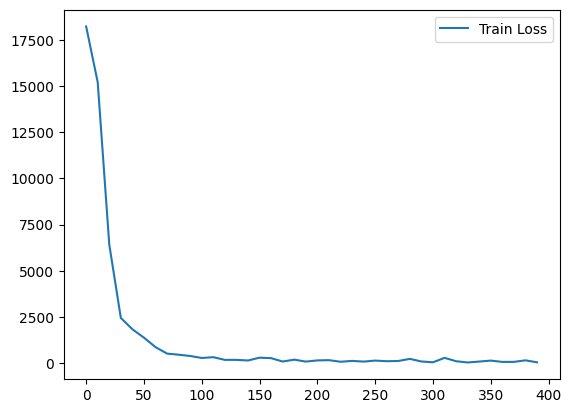

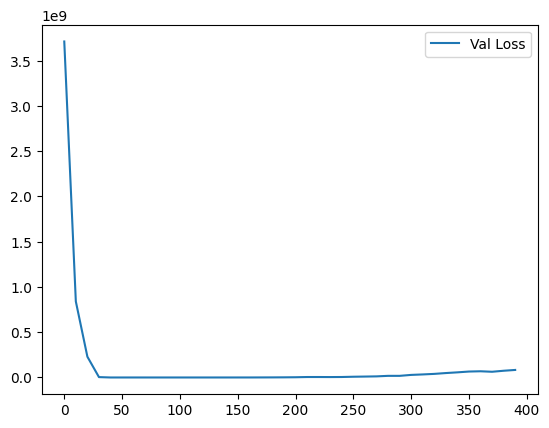

In [148]:
plot_loss(history_train, history_val)